# **Lista 3** de Aprendizagem Automática

## **Assuntos:** KNN e Árvores de Decisão

*   **Aluna:** Bárbara Neves
*   **Matrícula:** 507526

---



> <font color='blue'>**Jupyter notebook desenvolvido no Google Colab.**</font> Também pode ser acessado através do [link](https://github.com/barbaraneves/masters-machine-learning-course) no GitHub, sem alterações após o envio pelo SIGAA.



# Imports Principais

Neste notebook, utilizo apenas as bibliotecas presentes na célula abaixo, juntamente com alguns módulos da biblioteca **Scikit-learn**, **tqdm** e spicy.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Implementações

## Utils

<font color='red'>**Sobre o código:**</font> a seguir estão as funções auxiliares, utilitárias ou de suporte que são usadas para auxiliar na resolução das questões desta lista de exercícios. As três primeiras funções presentes na primeira célula desta seção foram criadas para a Lista 2 e reaproveitadas aqui.

In [ ]:
from sklearn.preprocessing import StandardScaler

# FUNÇÕES DA LISTA 2
def plot_class_counts(data, width=6, height=5, palette='coolwarm'):
  # Set the figure size
  plt.figure(figsize=(width, height))

  # Plot count of occurrences for each class
  sns.countplot(data=data, palette=palette)
  plt.xlabel('Classes')
  plt.ylabel('Count')
  plt.show()

def normalize_data(X):
  scaler = StandardScaler()
  X_norm = scaler.fit_transform(X)
  X_norm = pd.DataFrame(X_norm, columns=X.columns)

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  sns.lineplot(data=X, ax=axs[0], legend=False, palette='coolwarm_r')
  axs[0].set_title('Antes da Normalização')
  sns.lineplot(data=X_norm, ax=axs[1], legend=False, palette='coolwarm')
  axs[1].set_title('Depois da Normalização')
  plt.show()

  return X_norm.values

def plot_gaussian_distribution(data):
  sns.kdeplot(data, legend=False, palette='coolwarm', fill=True, common_norm=False)

  plt.title("Distribuição de X")
  plt.xlabel('Valores')
  plt.ylabel('Densidade')
  plt.show()

In [ ]:
def custom_classification_report(report, target_names):
  if target_names is None:
    target_names = list(range(len(report['precision'][0])))

  print("           precision   recall   f1-score")
  print("")
  for i, target_name in enumerate(target_names):
    print(f"{target_name:<8}   {np.mean(report['precision'][i]):.4f}      {np.mean(report['recall'][i]):.4f}   {np.mean(report['f1-score'][i]):.4f}")
  print("")
  print(f"std dev    {np.std(report['precision'][i]):.4f}      {np.std(report['recall'][i]):.4f}   {np.std(report['f1-score'][i]):.4f}")
  print("")
  print(f"acc                             {np.mean(report['accuracy']):.4f}")
  print(f"acc std dev                     {np.std(report['accuracy']):.4f}")

def classification_report_per_model(results, target_name=None):
  for model, report in results.items():
    print("--------------------------------------------------------------------")
    print(f"MODELO = {model}")
    print("--------------------------------------------------------------------")
    custom_classification_report(report, target_name)
    print("")

<!--
def plot_average_confusion_matrices(confusion_matrices, figsize=(9, 11), palette='coolwarm'):
    models = list(confusion_matrices.keys())
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, model in enumerate(models):
      row = i // n_cols
      col = i % n_cols
      ax = axes[row, col] if n_rows > 1 else axes[col]

      matrices = confusion_matrices[model]
      average_matrix = np.mean(matrices, axis=0)

      sns.heatmap(average_matrix,annot=True, fmt='.1g',
                  cmap=palette, ax=ax, center=np.max(average_matrix)/2)

      title_parts = model.split(" -> ")
      model_name = title_parts[0]
      model_params = title_parts[1] if len(title_parts) > 1 else ""
      title = f"{model_name}\n{model_params}"
      
      ax.set_title(title)
      
      classes = np.arange(average_matrix.shape[0])
      ax.set(xticks=np.arange(average_matrix.shape[1]) + 0.5,
             yticks=np.arange(average_matrix.shape[0]) + 0.5,
             xticklabels=classes,
             yticklabels=classes,
             ylabel='Verdadeiros',
             xlabel='Preditos')

      ax.set_aspect('equal')

    for i in range(n_models, n_rows * n_cols):
      row = i // n_cols
      col = i % n_cols
      fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    fig.tight_layout()

    plt.show()
-->

## Métricas e K-fold Cross Validation

<font color='red'>**Sobre o código:**</font> o código apresentado possui duas funções principais.

- A primeira função é **`get_classification_metrics`**, que calcula a matriz de confusão com base em `y_real` e `y_pred`, e retorna as métricas acurácia, precisão, revocação e F1-score.
- A segunda função é **`cross_val_kfold_score`**, reaproveitada da Lista 2 com algumas modificações, que recebe como entrada as variáveis `X`, `y`, `n_splits` (número de folds para a validação cruzada), `model` (modelo de Aprendizado de Máquina a ser ajustado), e `seed`. Essa função realiza uma **validação cruzada k-fold** e retorna um relatório contendo as métricas de avaliação para cada fold. O relatório inclui a acurácia, precisão, revocação e F1-score, métricas calculadas a partir da função `get_classification_metrics`.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

def get_classification_metrics(y_real, y_pred):
  cm = confusion_matrix(y_real, y_pred)
  accuracy = cm.diagonal().sum() / cm.sum()

  precision = cm.diagonal() / cm.sum(axis=0)
  recall = cm.diagonal() / cm.sum(axis=1)
  f1_score = 2 * (precision * recall) / (precision + recall)

  return accuracy, precision, recall, f1_score, cm

def cross_val_kfold_score(X, y, n_splits, model, seed=42):
  report = {
      'accuracy': [],
      'precision': [],
      'recall': [],
      'f1-score': []
  }
  cm_report = []

  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  for i, (train_index, test_index) in enumerate(tqdm(kfold.split(X), total=n_splits)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # if model.metric == 'mahalanobis':
    #   cov = np.cov(X_train.T)
    #   inv_cov = np.linalg.inv(cov)
    #   model.metric_params = {'VI': inv_cov}

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy, precision, recall, f1_score, cm = get_classification_metrics(y_test, y_pred)

    report['accuracy'].append(accuracy)
    report['precision'].append(precision)
    report['recall'].append(recall)
    report['f1-score'].append(f1_score)

    cm_report.append(cm)

  return report, cm_report

## K-Nearest Neighbors

<font color='red'>**Sobre o código:**</font> a classe criada **`KNeighborsClassifier`** e seus métodos fornecem docstrings autoexplicativas.

In [ ]:
from scipy.spatial.distance import mahalanobis

class KNeighborsClassifier:
  """
    Classificador K-Nearest Neighbors (KNN) para tarefas de classificação.

    Args:
      n_neighbors (int): número de vizinhos considerados para classificação.
      metric (str): métrica de distância a ser usada. Opções disponíveis: 'euclidean', 'mahalanobis'.

    Attributes:
      k (int): número de vizinhos considerados para classificação.
      metric (str): métrica de distância usada.

    Methods:
      calculate_distance(Xi, Xj): calcula a distância entre dois pontos de dados com base na métrica escolhida.
      distance_matrix(X_, X): calcula a matriz de distância entre dois conjuntos de pontos de dados.
      fit(X, y): ajusta o modelo KNN aos dados de entrada X e saída y.
      predict(X_): retorna as classes preditas para novos dados X_.

    Raises:
      ValueError: se `metric` não for uma métrica de distância válida.
  """

  def __init__(self, n_neighbors=None, metric='euclidean'):
    self.k = n_neighbors
    self.metric = metric

  def calculate_distance(self, Xi, Xj):
    """
      Calcula a distância entre dois pontos de dados com base na métrica escolhida.

      Parameters:
        Xi (numpy.ndarray): ponto de dados para o qual a distância é calculada.
        Xj (numpy.ndarray): ponto de dados para o qual a distância é calculada.

      Returns:
        distance (float): a distância entre Xi e Xj.
    """
    if self.metric == 'euclidean':
      return np.sqrt(np.sum((Xi - Xj) ** 2))
    elif self.metric == 'mahalanobis':
      return mahalanobis(Xi, Xj, np.linalg.inv(np.cov(self.X.T)))
    else:
      raise ValueError(f"Métrica inválida '{self.metric}'. Opções disponíveis: 'euclidean', 'mahalanobis'")

  def distance_matrix(self, X_, X):
    """
      Calcula a matriz de distância entre dois conjuntos de pontos de dados.

      Parameters:
        X_ (numpy.ndarray): pontos de dados a serem classificados.
        X (numpy.ndarray): pontos de dados de entrada.

      Returns:
        dist_matrix (numpy.ndarray): a matriz de distância entre X_ e X.
    """
    dist_matrix = np.zeros((X_.shape[0], X.shape[0]))

    for i in range(X_.shape[0]):
      for j in range(X.shape[0]):
        dist_matrix[i, j] = self.calculate_distance(X_[i, :], X[j, :])

    return dist_matrix

  def fit(self, X, y):
    """
      Ajusta o modelo KNN aos dados de entrada X e saída y.

      Parameters:
        X (ndarray): dados de entrada.
        y (ndarray): vetor de classes correspondentes.

      Returns:
        None
    """
    self.classes = np.unique(y)
    self.X = X
    self.y = y.astype(int)

  def predict(self, X_):
    """
      Realiza a predição das classes para os dados de entrada X.

      Parameters:
        X_ (numpy.ndarray): dados de entrada.

      Returns:
        y_pred (numpy.ndarray): valores alvo preditos.
    """
    dist_matrix = self.distance_matrix(X_, self.X)
    knn = np.argsort(dist_matrix)[:, :self.k]

    y_pred = self.classes[np.argmax(np.apply_along_axis(np.bincount, 1, self.y[knn], minlength=self.classes.shape[0]), axis=1)]

    return y_pred

## Árvore de Decisão

<font color='red'>**Sobre o código:**</font> import da classe `DecisionTreeClassifier`do Scikit-learn, capaz de realizar classificação multiclasse com o algoritmo Árvore de Decisão.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Questão 1

Considere o conjunto de dados disponível em `kc2.csv`, organizado em 22 colunas, sendo as 21 primeiras colunas os atributos e a última coluna a saída.

Os 21 atributos são referentes à caracterização de códigos-fontes para processamento de dados na NASA. A saída é a indicação de ausência (0) ou existência (1) de defeitos (os dados foram balanceados via subamostragem).

In [ ]:
df = pd.read_csv('kc2.csv', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,2.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,0.0
1,39.0,4.0,1.0,2.0,105.0,520.19,0.07,13.89,37.44,7227.91,...,29.0,1.0,4.0,2.0,12.0,19.0,61.0,44.0,7.0,0.0
2,1.0,1.0,1.0,1.0,6.0,15.51,0.40,2.50,6.20,38.77,...,0.0,0.0,0.0,0.0,5.0,1.0,5.0,1.0,1.0,0.0
3,15.0,1.0,1.0,1.0,55.0,224.81,0.17,5.73,39.25,1287.55,...,12.0,0.0,1.0,0.0,6.0,11.0,34.0,21.0,1.0,0.0
4,12.0,2.0,1.0,2.0,15.0,45.00,0.17,6.00,7.50,270.00,...,8.0,1.0,0.0,0.0,6.0,2.0,11.0,4.0,3.0,0.0


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,2.140000e+02,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,59.247664,7.752336,3.845794,5.616822,157.172897,978.048084,0.202897,13.502056,38.770607,3.800393e+04,...,45.266355,3.490654,6.897196,0.485981,11.322430,21.691589,96.242991,62.261682,14.387850,0.500000
std,112.877762,16.222611,10.085063,12.009890,341.934668,2725.522314,0.223949,13.979825,41.260827,1.741898e+05,...,94.060160,7.646375,12.708678,1.506571,7.138059,30.178627,209.900170,132.259301,32.442134,0.501172
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,6.000000,1.000000,1.000000,1.000000,12.250000,36.500000,0.050000,3.000000,9.292500,1.000000e+02,...,4.000000,0.000000,0.000000,0.000000,5.000000,3.000000,8.000000,4.000000,1.000000,0.000000
50%,29.000000,3.000000,1.000000,2.500000,69.500000,325.655000,0.090000,10.000000,31.260000,3.258485e+03,...,22.000000,0.000000,3.000000,0.000000,11.000000,15.000000,39.500000,27.500000,5.000000,0.500000
75%,71.500000,8.000000,4.000000,6.000000,184.000000,1008.702500,0.300000,20.205000,55.107500,1.961718e+04,...,53.750000,3.000000,9.000000,0.000000,16.000000,29.750000,113.000000,72.500000,15.000000,1.000000
max,1275.000000,180.000000,125.000000,143.000000,3982.000000,33814.560000,1.000000,103.530000,415.060000,2.147484e+06,...,1107.000000,44.000000,121.000000,11.000000,47.000000,325.000000,2469.000000,1513.000000,361.000000,1.000000


In [ ]:
df.iloc[:, -1:].value_counts()

21 
0.0    107
1.0    107
dtype: int64

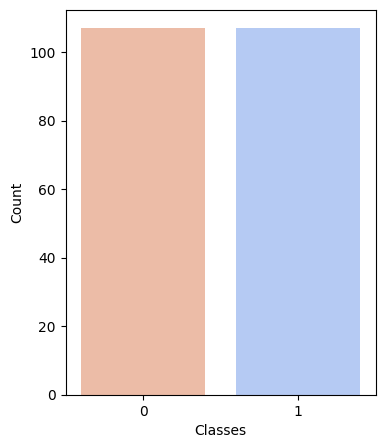

In [ ]:
class_data = [i*j for i, j in df.iloc[:, -1:].value_counts().items()]

plot_class_counts(class_data, width=4, height=5, palette='coolwarm_r')

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:].values.ravel()

X.shape, y.shape

((214, 21), (214,))

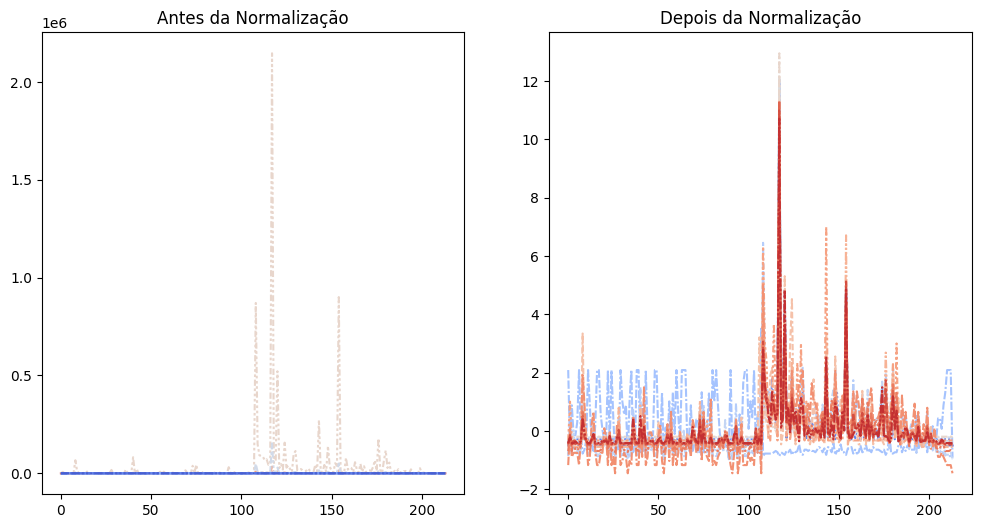

In [ ]:
X_norm = normalize_data(X)
X = X.values

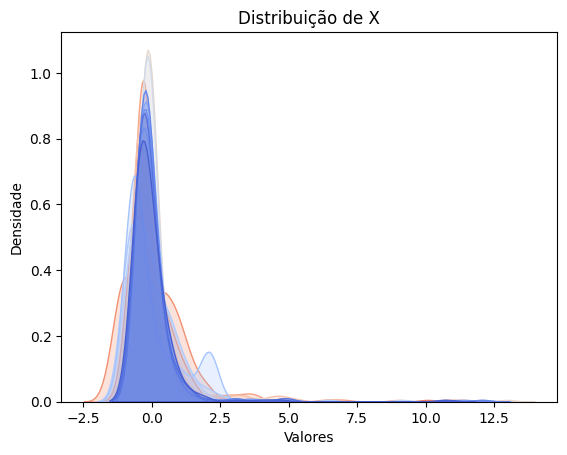

In [ ]:
plot_gaussian_distribution(data=X_norm)

---

**Observações:**

> Para o KNN, uma das abordagens de modelo de classificação pedida na Questão 1, é uma boa prática normalizar os dados antes de treinar o modelo.

> O desempenho do KNN pode ser influenciado pela escala dos atributos. O KNN baseia-se na distância entre os pontos de dados para realizar a classificação, e a escala dos atributos pode ter um impacto significativo na distância calculada. Portanto, é importante normalizar os atributos para que eles estejam na mesma escala, permitindo uma comparação adequada das distâncias.

> Por outro lado, a Árvore de Decisão toma decisões com base em regras que comparam os valores dos atributos diretamente, sem levar em consideração a escala. Portanto, a normalização dos dados não é necessária para o algoritmo de Árvore de Decisão.

> Dessa forma, para o pipeline de execucação dos modelos, a normalização dos dados feita (`X_norm`) foi usada apenas para o algoritmo KNN. Para o algoritmo Árvore de Decisão, foram usados os dados brutos (`X`).

> Os plots dos gráficos acima ilustram o processo de normalização realizado para X (`X_norm`).

## Alternativas a) e b)

> **a)** Considerando uma validação cruzada em 10 *folds*, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens
abaixo:
> - **KNN** (escolha $k = 1$ e $k = 5$, distância Euclidiana e Mahalonobis,
totalizando 4 combinações);
> - **Árvore de Decisão** (usar uma implementação já existente
com índices de impureza de gini e entropia).

> **b)** Para cada modelo criado, reporte valor médio e desvio padrão das métricas de **acurácia**, **revocação (R)**, **precisão (P)** e **F1-score (F1)**.

In [ ]:
models = {
    "KNeighborsClassifier -> n_neighbors=1, metric='euclidean'": KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    "KNeighborsClassifier -> n_neighbors=1, metric='mahalanobis'": KNeighborsClassifier(n_neighbors=1, metric='mahalanobis'),
    "KNeighborsClassifier -> n_neighbors=5, metric='euclidean'": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    "KNeighborsClassifier -> n_neighbors=5, metric='mahalanobis'": KNeighborsClassifier(n_neighbors=5, metric='mahalanobis'),
    "DecisionTreeClassifier -> criterion='gini'": DecisionTreeClassifier(criterion='gini'),
    "DecisionTreeClassifier -> criterion='entropy'": DecisionTreeClassifier(criterion='entropy')
}

In [ ]:
# A cada iteração, verifica se o primeiro elemento de k.split() é igual a 'DecisionTreeClassifier'
  # Se for verdadeiro, significa que o modelo correspondente é um DecisionTreeClassifier e a validação cruzada é executada com o conjunto de dados X não normalizado
  # Caso contrário, o modelo é executado com o conjunto de dados X_norm, que é a versão normalizada do conjunto de dados original X}
results = {(k): (cross_val_kfold_score(X, y, n_splits=10, model=model) if k.split()[0] == 'DecisionTreeClassifier' else cross_val_kfold_score(X_norm, y, n_splits=10, model=model)) for k, model in models.items()}

100%|██████████| 10/10 [00:00<00:00, 79.62it/s]


In [ ]:
metrics_report = {k: v[0] for k, v in results.items()}
confusion_matrices = {k: v[1] for k, v in results.items()}

In [ ]:
classification_report_per_model(metrics_report)

--------------------------------------------------------------------
MODELO = KNeighborsClassifier -> n_neighbors=1, metric='euclidean'
--------------------------------------------------------------------
           precision   recall   f1-score

0          0.6750      0.6795   0.6758
1          0.5909      0.5917   0.5901

std dev    0.0455      0.0083   0.0186

acc                             0.7385
acc std dev                     0.0975

--------------------------------------------------------------------
MODELO = KNeighborsClassifier -> n_neighbors=1, metric='mahalanobis'
--------------------------------------------------------------------
           precision   recall   f1-score

0          0.5455      0.5470   0.5417
1          0.5909      0.5917   0.5901

std dev    0.0455      0.0083   0.0186

acc                             0.6734
acc std dev                     0.0914

--------------------------------------------------------------------
MODELO = KNeighborsClassifier -> n_neig

---

**Observações gerais:**

> Analisando os resultados para os diferentes modelos e parâmetros, podemos observar as seguintes características.

> ***Método* `KNeighborsClassifier`**

>> **`n_neighbors=1, metric='euclidean'`**
>> - As métricas P, R e F1 são relativamente altas para ambas as classes, indicando um bom desempenho geral.
>> - A acurácia média é de 0.74, com um desvio padrão de ~0.10, o que sugere que o modelo tem uma consistência razoável em diferentes folds da validação cruzada.

>> **`n_neighbors=1, metric='mahalanobis'`**
>> - Os resultados de P, R e F1 são inferiores aos obtidos com a distância Euclidiana.
>> - A acurácia média é de 0.67, com um desvio padrão de 0.91, indicando um desempenho um pouco inferior ao modelo anterior.

>> **`n_neighbors=5, metric='euclidean'`**
>> - O modelo com $k=5$ e distância Euclidiana mostra resultados semelhantes ao modelo com $k=1$ e distância Euclidiana.
>> - No entanto, as métricas P, R e F1 para a classe 1 são ligeiramente inferiores.
>> - A acurácia média é de ~0.79, com um desvio padrão de ~0.12, indicando um desempenho razoavelmente consistente.

>> **`n_neighbors=5, metric='mahalanobis'`**
>> - O modelo com $k=5$ e distância de Mahalanobis apresenta resultados mais equilibrados entre as classes do que o modelo com distância Euclidiana.
>> - A acurácia média é de 0.77, com um desvio padrão de 0.85, sugerindo um desempenho consistente.

> ***Método* `DecisionTreeClassifier`**
  
>> **`criterion='gini'`**
>> - Os resultados de P, R e F1 são razoáveis para ambas as classes.
>> - A acurácia média é de 0.74, com um desvio padrão de ~0.1, indicando um desempenho consistente, mas com uma variabilidade relativamente alta.

>> **`criterion='entropy'`**
>> - Os resultados de P, R e F1 são ligeiramente superiores aos obtidos com o critério de gini.
>> - A acurácia média é de ~0.71, com um desvio padrão de 0.07, indicando um desempenho consistente, mas com uma variabilidade moderada.

> Em resumo, os modelos KNN com $k=1$ e distância Euclidiana e KNN com $k=5$ e distância Euclidiana apresentaram um desempenho geralmente bom. Eles obtiveram altos valores de P, R e F1 para ambas as classes, indicando uma boa capacidade de classificação. Além disso, a acurácia média foi relativamente alta e houve consistência nos resultados entre diferentes folds da validação cruzada.

> O uso da distância de Mahalanobis no modelo KNN não resultou em uma melhora significativa nos resultados em comparação com a distância Euclidiana. Isso sugere que a distância Euclidiana foi mais adequada para o conjunto de dados e problema em questão.

> Quanto aos modelos com Árvore de Decisão, eles tiveram um desempenho razoável, mas com uma variabilidade um pouco mais alta em comparação com os modelos KNN.

> Com base nas informações fornecidas, pode-se inferir que os dados possuem características que adequam-se tanto ao modelo KNN, que considera a estrutura local dos dados, quanto ao modelo de Árvore de Decisão, que considera a estrutura global dos dados.
> 1. No caso do modelo KNN, é observado que o desempenho foi geralmente bom, o que sugere que a estrutura local dos dados é importante, pois instâncias semelhantes tendem a pertencer à mesma classe.
> 2. Por outro lado, os modelos de Árvore de Decisão também apresentaram um desempenho razoável, embora com uma variabilidade um pouco mais alta. Os resultados das métricas indicam que a estrutura global dos dados é relevante, pois as regras de decisão podem ser representadas de forma hierárquica.